In [1]:
# # Google Colab preparation

# %%capture

# !pip install scikit-optimize
# !pip install imblearn

# !git clone https://github.com/ReadingHui/tabular-playground-s4e10-loan-approval

# import sys
# sys.path.insert(0,'/content/tabular-playground-s4e10-loan-approval')

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import preprocess

import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


# Global Variables

In [2]:
# # In Google Colab
# train_path = '/content/tabular-playground-s4e10-loan-approval/train.csv'
# test_path = '/content/tabular-playground-s4e10-loan-approval/test.csv'

# In Local machine
train_path = 'train.csv'
test_path = 'test.csv'

random_state = 1048576
target = 'loan_status'
cat_features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

num_features = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Data Loading and Preprocessing

In [3]:
# Data Loading
X_train, X_test, y_train, y_test = preprocess.DataImport.get_train_test(train_path, index_col=0, target=target, random_state=random_state, verbose=1)

# Remove outliers
X_train, y_train = preprocess.Outliers.remove_outliers(X_train, y_train, verbose=1)

# One-Hot Encode
encoder = preprocess.CategoryEncoder(cat_features=cat_features, method='one_hot')
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

# Standard Scaling
scaler = StandardScaler()
features = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

# Oversampling
print(f'Target distribution before oversampling: (0: {round(y_train.sum() / y_train.size * 100, 2)}%, 1: {round((1 - y_train.sum() / y_train.size) * 100, 2)}%)')
oversampler = RandomOverSampler(random_state=random_state)
X_train, y_train = oversampler.fit_resample(X_train, y_train)
print(f'X_train shape after oversampling: {X_train.shape}; y_train shape after oversampling: {X_train.shape}')
print(f'Target distribution after oversampling: (0: {round(y_train.sum() / y_train.size * 100, 2)}%, 1: {round((1 - y_train.sum() / y_train.size) * 100, 2)}%)')

# Train - Validation Split
X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1, random_state=random_state)

print(f'Shape of X_train is: {X_train.shape}; shape of y_train is: {y_train.shape}')
print(f'Shape of X_val is: {X_val.shape}; shape of y_test is: {y_val.shape}')

# Casting everything to pytorch tensor
X_train = torch.tensor(X_train.values, device=device, dtype=torch.float32)
y_train = torch.tensor(y_train.values, device=device, dtype=torch.float32)
X_val = torch.tensor(X_val.values, device=device, dtype=torch.float32)
y_val = torch.tensor(y_val.values, device=device, dtype=torch.float32)
X_test = torch.tensor(X_test.values, device=device, dtype=torch.float32)
y_test = torch.tensor(y_test.values, device=device, dtype=torch.float32)

Shape of X_train is: (52780, 11); shape of y_train is: (52780,)
Shape of X_test is: (5865, 11); shape of y_test is: (5865,)
New shape of X_train is: (52639, 11); New shape of y_train is: (52639,)
Target distribution before oversampling: (0: 14.22%, 1: 85.78%)
X_train shape after oversampling: (90312, 26); y_train shape after oversampling: (90312, 26)
Target distribution after oversampling: (0: 50.0%, 1: 50.0%)
Shape of X_train is: (81280, 26); shape of y_train is: (81280,)
Shape of X_val is: (9032, 26); shape of y_test is: (9032,)


# Model building

In [14]:
# Define the neural network model
class BinaryClassificationNN(nn.Module):
    def __init__(self):
        super(BinaryClassificationNN, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(in_features=26, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.fc3 = nn.Linear(in_features=16, out_features=8)
        self.fc4 = nn.Linear(in_features=8, out_features=1)

        # Activation function
        self.relu = nn.ReLU()

        # Sigmoid for probability output
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self.init_weights()  # Custom weight initialization

    def init_weights(self):
        # Initialize weights with Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)
        nn.init.xavier_uniform_(self.fc4.weight)

        # Optionally, initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)
        nn.init.zeros_(self.fc4.bias)


    def forward(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.relu(self.fc3(X))
        X = self.sigmoid(self.fc4(X))  # Sigmoid for binary classification
        return X

   

In [18]:
def train_model(model: nn.Module, X: torch.Tensor, y: torch.Tensor, eval_set: tuple[torch.Tensor] = None, num_epochs: int = 10, batch_size: int = 32, shuffle: bool = True, 
                learning_rate: float = 0.01, weight_decay: float = 1e-3, cv: int = 0, criterion: torch.nn.modules.loss = nn.BCELoss(), verbose: int = 1):
    # Initialize optimizer and loss_list
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    loss_list = []
    scores = {"train": [], "val": []}

    # Initialize data_laoder
    X = X.clone()
    y = y.clone()
    train_tensor = data_utils.TensorDataset(X, y)
    train_loader = data_utils.DataLoader(dataset=train_tensor, batch_size=batch_size, shuffle=shuffle)
    if eval_set:
        X_val = eval_set[0].clone()
        y_val = eval_set[1].clone()
    
    for epoch in range(num_epochs):  # Training loop
            total_loss = 0
            for batch_idx, (inputs, labels) in enumerate(train_loader): # For each batch
                # Forward pass
                outputs = model(inputs)
                outputs = torch.squeeze(outputs)

                # Compute the loss
                loss = criterion(outputs, labels)

                # Backpropagation and optimization
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward() # Backpropagate
                optimizer.step() # Update weights

                total_loss += loss.item()

                if verbose > 1:
                    print_freq = num_epochs // 10
                    if batch_idx % print_freq == 0:
                        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}") # Printing loss
                elif verbose == 1 and batch_idx == len(train_loader) - 1 and (X_val is None or y_val is None):
                    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {round(total_loss / len(train_loader), 4)}, Training Score: {round(roc_auc_score(y, model(X).detach().numpy()), 4)}") # Printing loss

            # Store the loss value for this epoch
            loss_list.append(round(total_loss / len(train_loader), 4))
            scores['train'].append(round(roc_auc_score(y, model(X).detach().numpy()), 4))
            if eval_set:
                # Evaluate the model on the validation set
                scores['val'].append(round(roc_auc_score(y_val, model(X_val).detach().numpy()), 4))
                if verbose > 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {round(total_loss / len(train_loader), 4)}, Training Score: {round(roc_auc_score(y, model(X).detach().numpy()), 4)}, Validation Score: {round(scores['val'][-1], 4)}")

            history = {}
            history['loss'] = loss_list
            history['scores'] = scores

    return history





In [21]:
torch.manual_seed(random_state)
model = BinaryClassificationNN()
history = train_model(model, X_train, y_train, (X_val, y_val), 20, learning_rate=0.001)

Epoch [1/20], Average Loss: 0.3609, Training Score: 0.9294, Validation Score: 0.924
Epoch [2/20], Average Loss: 0.3248, Training Score: 0.9324, Validation Score: 0.9277
Epoch [3/20], Average Loss: 0.3186, Training Score: 0.9348, Validation Score: 0.9298
Epoch [4/20], Average Loss: 0.3152, Training Score: 0.9354, Validation Score: 0.9293
Epoch [5/20], Average Loss: 0.3129, Training Score: 0.9362, Validation Score: 0.9307
Epoch [6/20], Average Loss: 0.3111, Training Score: 0.9364, Validation Score: 0.9306
Epoch [7/20], Average Loss: 0.3099, Training Score: 0.937, Validation Score: 0.9304
Epoch [8/20], Average Loss: 0.308, Training Score: 0.9379, Validation Score: 0.9317
Epoch [9/20], Average Loss: 0.3065, Training Score: 0.9379, Validation Score: 0.9307
Epoch [10/20], Average Loss: 0.3063, Training Score: 0.9392, Validation Score: 0.9321
Epoch [11/20], Average Loss: 0.3047, Training Score: 0.9396, Validation Score: 0.9342
Epoch [12/20], Average Loss: 0.3037, Training Score: 0.9396, Valid

In [23]:
def plot_loss(history, loss: bool = True, score: bool = False):
    num_epochs = len(history['loss'])
    if not loss and not score:
        raise ValueError('Cannot have both loss and score set as False')

    if loss:
        plt.plot(range(1, num_epochs+1), history['loss'], marker='o')
    if score:
        plt.plot(range(1, num_epochs+1), history['scores']['train'], marker='x')
        plt.plot(range(1, num_epochs+1), history['scores']['val'], marker='x')

    if loss and score:
        plt.title('Training Loss and Scores Over Epochs')
    elif score:
        plt.title('Scores Over Epochs')
    elif loss:
        plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

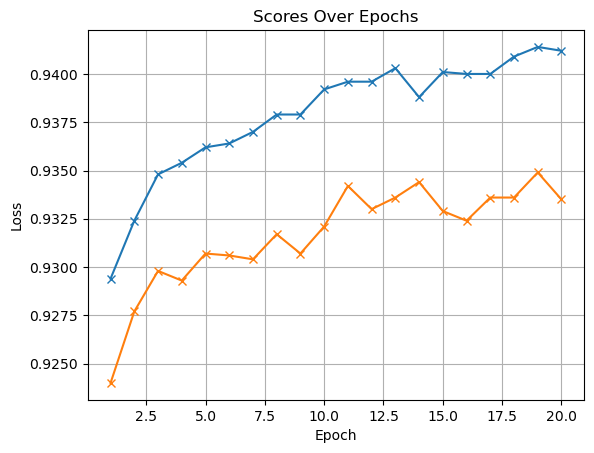

In [26]:
plot_loss(history, loss=False, score=True)

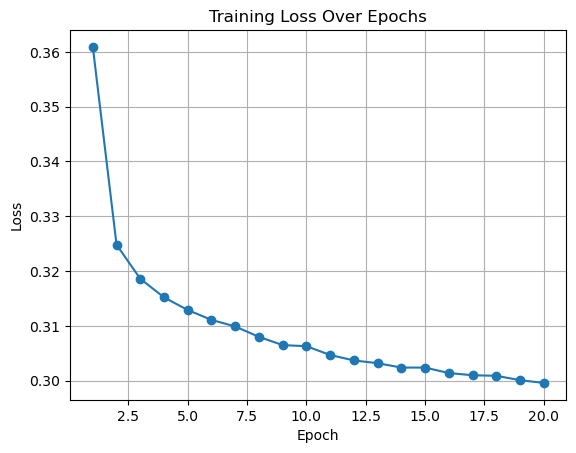

In [22]:
num_epochs = 20


plt.plot(range(1, num_epochs+1), history['loss'], marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# _, axes = plt.subplots(nrows=1, ncols=2, figsize=(8 * 2, 6 * 1))
# axes[0].plot(range(1, num_epochs+1), loss_hists[32], marker='o')
# axes[0].set_title('Training Loss Over Epochs with batch_size = 32')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Loss')
# axes[0].grid(True)

# axes[1].plot(range(1, num_epochs+1), loss_hists[64], marker='o')
# axes[1].set_title('Training Loss Over Epochs with batch_size = 64')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')
# axes[1].grid(True)

plt.show()